In [1]:
model_path = '../tflite_model.tflite'

import cv2 as cv
from test_tflite import Tester
from matplotlib import pyplot as plt
from utils.util import *
from matplotlib import pyplot as plt
from pathlib import Path

# test one image with given path

If showing within Jupyter notebook is not necessary, ignore the current code and run the code below:
<pre><code>
save_dir = '../test_result'
image_path = '../data/KITTI/testing/image_2/IMG_7178.jpg'
tester = Tester(model_path, save_dir = save_dir)
image =  cv.resize(cv.imread(image_path), tuple(tester.image_size[::-1]))
det_results = tester.test_one_image(image, save_result=True, save_name = Path(image_path).name)
</code></pre>

In [2]:
image_path = '../data/KITTI/testing/image_2/IMG_0066.JPG'
def draw_boxes(image, det_boxes, det_probs, det_classes, color):
    for bbox, prob, det_class in zip(det_boxes, det_probs, det_classes):
        label = det_class+': (%.2f)' % prob
        xmin, ymin, xmax, ymax = [int(b) for b in bbox_transform(bbox)]
        cv.rectangle(image, (xmin, ymin), (xmax, ymax), color, 1)
        cv.putText(image, label, (xmin, ymax), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

In [3]:
def map_feature(image, template, ratio_thresh):
    akaze = cv.AKAZE_create()
    key_points, descriptors = akaze.detectAndCompute(template, None)
    key_points2, descriptors2 = akaze.detectAndCompute(image, None)
    matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_BRUTEFORCE_HAMMING)
    knn_matches = matcher.knnMatch(descriptors, descriptors2, 2)
    good_matches = [m for m, n in knn_matches if m.distance < ratio_thresh * n.distance]
    img_matches = np.empty((max(template.shape[0], image.shape[0]), template.shape[1]+image.shape[1], 3), dtype=np.uint8)
    cv.drawMatches(template, key_points, image, key_points2, good_matches, img_matches, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    obj = np.empty((len(good_matches), 2), dtype=np.float32)
    scene = np.empty((len(good_matches), 2), dtype=np.float32)
    for i in range(len(good_matches)):
        obj[i, 0] = key_points[good_matches[i].queryIdx].pt[0]
        obj[i, 1] = key_points[good_matches[i].queryIdx].pt[1]
        scene[i, 0] = key_points2[good_matches[i].trainIdx].pt[0]
        scene[i, 1] = key_points2[good_matches[i].trainIdx].pt[1]
    H, _ = cv.findHomography(scene, obj, cv.RANSAC)
    return cv.warpPerspective(src=image, M=H, dsize=template.shape[1::-1])

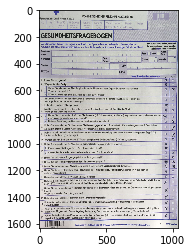

In [4]:
tester = Tester(model_path=model_path)
image = cv.resize(cv.imread(image_path), tuple(tester.image_size[::-1]))
template = cv.resize(cv.imread('../data/template_p1.jpg'), tuple(tester.image_size[::-1]))
unwarped = map_feature(image, template, .75)
plt.imshow(unwarped)

In [5]:
det_results = tester.test_one_image(unwarped)
class_list = [tester.mc.CLASS_NAMES[class_idx] for class_idx in det_results['classes']]
draw_boxes(unwarped, det_results['boxes'], det_results['probs'],class_list, color = (255,0,0))

## visualize result

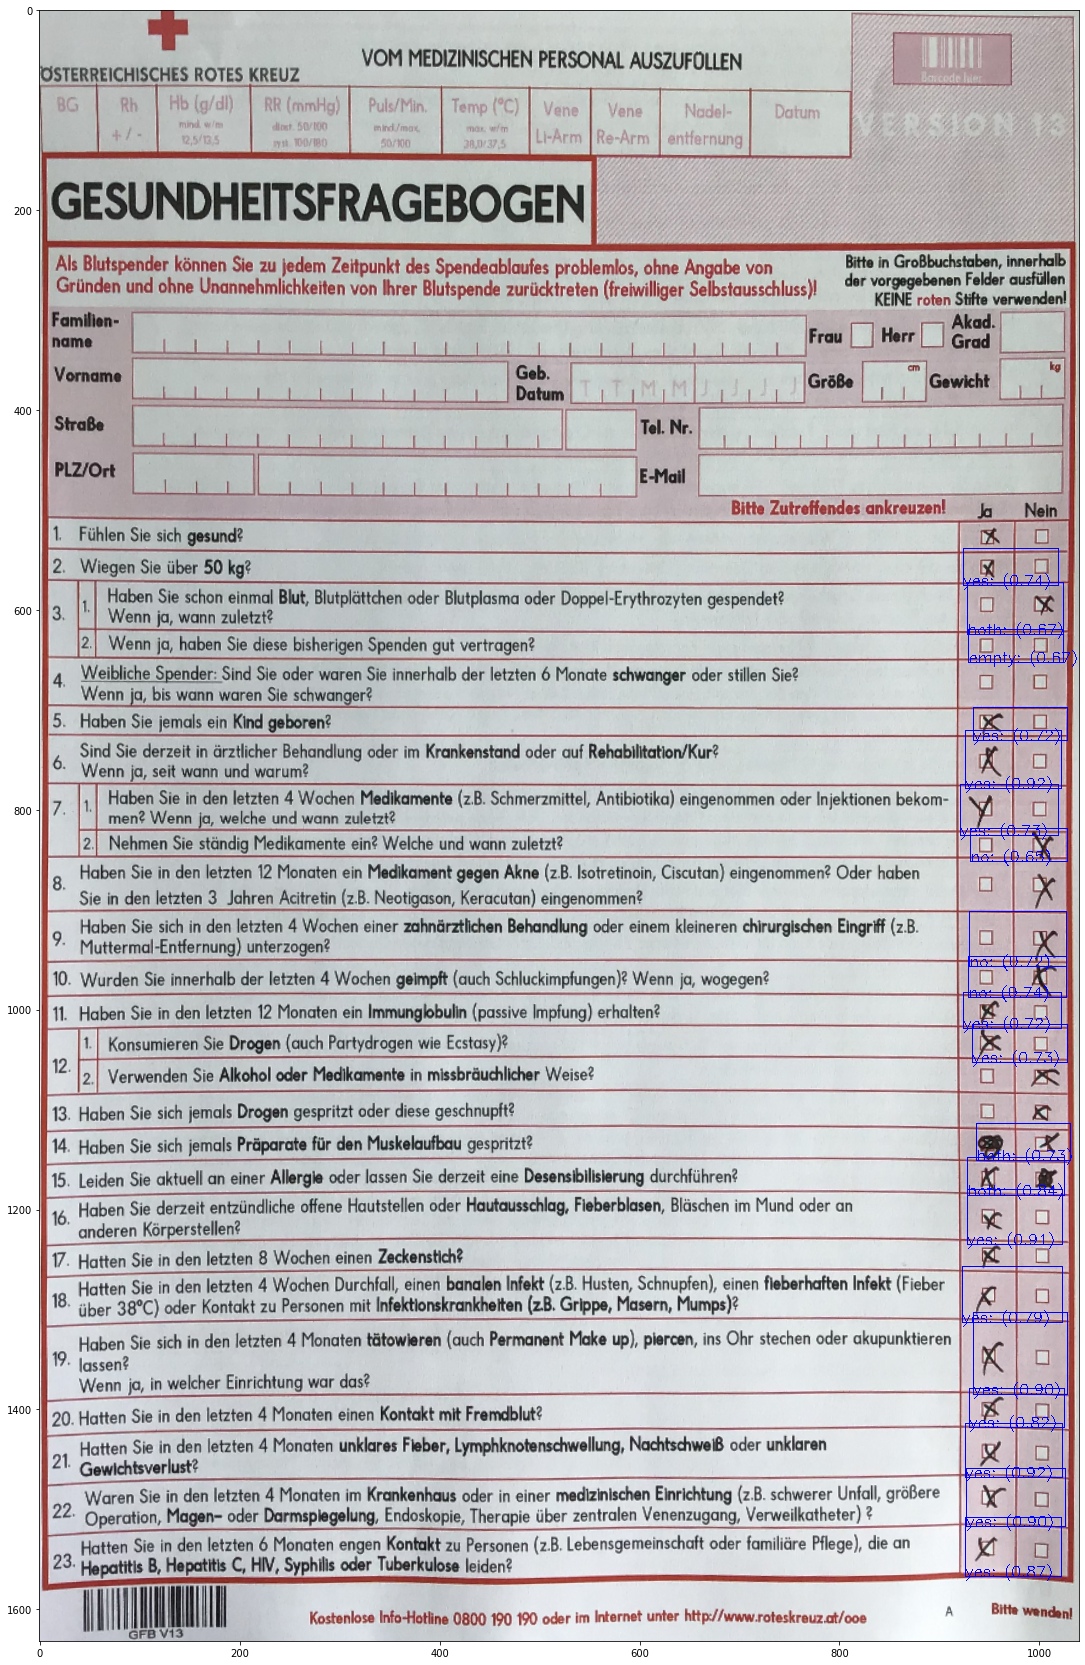

In [6]:
plt.figure(figsize = (20,30))
plt.imshow(cv.cvtColor(unwarped, cv.COLOR_BGR2RGB))

## test images under a folder



In [5]:
save_dir = '../test_result'
image_dir = '../data/KITTI/testing'

det_results = Tester(model_path, image_dir, save_dir).test_images(save_result=True)